# Fellowship.ai Challenge
## ULMFiT Sentiment

In [0]:
# Download data and pretrained models

In [1]:
! wget "http://nlp.stanford.edu/data/glove.6B.zip"
! unzip -q -n "glove.6B.zip"

--2019-05-27 16:33:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-05-27 16:33:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-05-27 16:33:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
! python -m spacy download en
! python -m spacy download en_core_web_md


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

     |████████████████████████████████| 120.9MB 674kB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-80utvhwf/wheels/db/5d/d0/ccdad6b01f9695b4a33793158530b3228223ee31463441663d
Successfully built en-core-web-md

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [3]:
from google.colab import files
con =files.upload()

Saving contractions.py to contractions.py


### Tweets Sentiment data

Code Adapted from : [Link](https://github.com/google-research/bert/blob/master/run_classifier.py)

Pretrained Model : [Link](https://github.com/google-research/bert#pre-trained-models)

Paper BERT : [Link](https://arxiv.org/pdf/1810.04805.pdf)

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import time
import spacy
import nltk
import os
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Embedding, Dense, Input, CuDNNLSTM, GRU, CuDNNGRU, Bidirectional
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.utils import to_categorical
path = Path("data")
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline


nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [6]:
print (data.shape)

(14640, 20)


#  Exploratory data analysis
##  Preprocessing Text

In [0]:
def preprocess_text(text):
    
    #strip html tags
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    #remove accented characters
    new_text = unicodedata.normalize('NFKD', stripped_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #expand contractions
    expanded_text = expand_contractions(new_text)
    
    #remove special characters and digits
    pattern = r'[^a-zA-z0-9\s]'
    no_sc_text = re.sub(pattern, '', expanded_text)
    
    #stemming
    ps = nltk.porter.PorterStemmer()
    stem_text = ' '.join([ps.stem(word) for word in no_sc_text.split()])
    
    
    #lemmatization
    nlp_text = nlp(stem_text)
    lemma_text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in nlp_text])
    
    
    #remove stopwords
    filtered_text = remove_stopwords(lemma_text)
    
    
    return filtered_text

In [0]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [0]:
def remove_stopwords(text, is_lower_case=False):
    
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [10]:
start = time.time()

preprocessed_text = []
for i in tqdm(range(len(data))):  
    preprocessed_text.append(preprocess_text(data['text'][i]))
  
print ('Preprocessing took {:.2f} seconds'.format(time.time()-start))  

100%|██████████| 14640/14640 [05:17<00:00, 49.82it/s]

Preprocessing took 317.28 seconds


In [11]:
print ('Before preprocessing:')
print (data['text'].values[:5])

Before preprocessing:
['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it"]


In [12]:
print ('After preprocessing:')
print (preprocessed_text[:5])

After preprocessing:
['virginamerica dhepburn say', 'virginamerica plu ad commerci experi tacki', 'virginamerica not today must mean need take anoth trip', 'virginamerica realli aggress blast obnoxi entertain guest face littl recour', 'virginamerica realli big bad thing']


In [13]:
NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

# convert each word into token(integer) with maximum number of words based on frequency is 20000
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(preprocessed_text)

# stitch back the words into sequences with filtering symbols and converting to lower
sequences = tokenizer.texts_to_sequences(preprocessed_text)
# convert all sentences to equal length of 100
sentences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13851 unique tokens.


## Custom Embedding Layer using LSTM

In [14]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100) (11712, 3)
Validation: (2928, 100) (2928, 3)


In [15]:
num_classes = 3
EMBED_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)

# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_DIM)(sequence_input)

x = LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(embedded_sequences)
x = LSTM(128, dropout=0.5, recurrent_dropout=0.5)(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          4155600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          570368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 4,923,475
Trainable params: 4,923,475
Non-trainable params: 0
___________

In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [17]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 49s 4ms/step - loss: 0.7322 - acc: 0.6885 - val_loss: 0.5877 - val_acc: 0.7531
Epoch 2/10
11712/11712 [==============================] - 46s 4ms/step - loss: 0.4719 - acc: 0.8168 - val_loss: 0.5157 - val_acc: 0.7944
Epoch 3/10
11712/11712 [==============================] - 46s 4ms/step - loss: 0.3428 - acc: 0.8710 - val_loss: 0.5353 - val_acc: 0.7954
Epoch 4/10
11712/11712 [==============================] - 46s 4ms/step - loss: 0.2541 - acc: 0.9086 - val_loss: 0.5968 - val_acc: 0.7896
Epoch 5/10
11712/11712 [==============================] - 46s 4ms/step - loss: 0.2019 - acc: 0.9282 - val_loss: 0.6720 - val_acc: 0.7821
Epoch 6/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.1647 - acc: 0.9422 - val_loss: 0.7565 - val_acc: 0.7719
Epoch 00006: early stopping


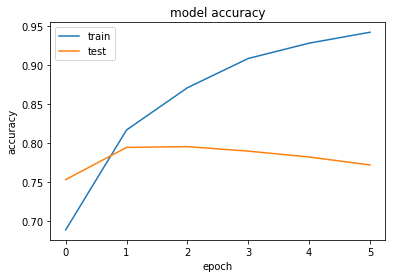

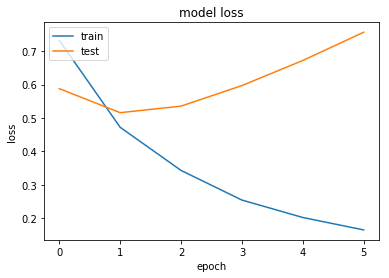

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Custom Embedding Layer using BiLSTM

In [19]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100) (11712, 3)
Validation: (2928, 100) (2928, 3)


In [20]:
EMBED_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)

# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_DIM)(sequence_input)

x = Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))(embedded_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5))(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          4155600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          1140736   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 5,953,491
Trainable params: 5,953,491
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [22]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 102s 9ms/step - loss: 0.7155 - acc: 0.6983 - val_loss: 0.5748 - val_acc: 0.7609
Epoch 2/10
11712/11712 [==============================] - 98s 8ms/step - loss: 0.4467 - acc: 0.8303 - val_loss: 0.5317 - val_acc: 0.7971
Epoch 3/10
11712/11712 [==============================] - 98s 8ms/step - loss: 0.3075 - acc: 0.8875 - val_loss: 0.5534 - val_acc: 0.7917
Epoch 4/10
11712/11712 [==============================] - 97s 8ms/step - loss: 0.2320 - acc: 0.9185 - val_loss: 0.6197 - val_acc: 0.7838
Epoch 5/10
11712/11712 [==============================] - 97s 8ms/step - loss: 0.2846 - acc: 0.8992 - val_loss: 0.7706 - val_acc: 0.6977
Epoch 00005: early stopping


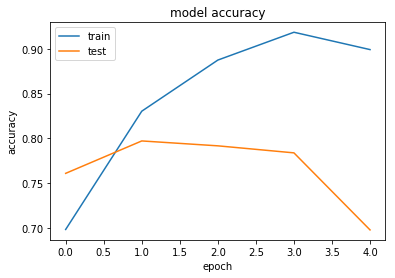

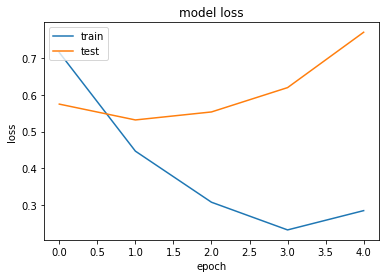

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()